In [1]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD, Adam
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from functools import partial

import pandas as pd
import time

C:\Users\yurin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib notebook

In [3]:
df = pd.DataFrame(columns=['name', 'acc', 'val_acc', 'val_top3_acc', 'test_acc',
                           'feature', 'delta', 'inference_time', 'augmented_set', 'parameters', 'epochSGD', 'epochAdam'])
line = {'name': None, 'acc':None, 'val_acc':None, 'val_top3_acc':None, 'test_acc':None,
                           'feature':None, 'delta':None, 'inference_time':None, 
                            'augmented_set':None, 'parameters':None, 'epochSGD': None, 'epochAdam' : None}

# Creating dataset

In [4]:
#choose which dictionary to use
choice =    'mfcc'
useDelta =  False

data = {}
    
selected = 0

if choice == 'mfcc':
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/mfccDictDD'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/mfccDict'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #loading in usedDict of the mfcc dict
        with open(name, 'rb') as f: 
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

elif choice == 'logfilter':
    #retrieving of used values for the computation of mfcc
    with open('variables/lfValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/logfiltDictDD'+functions.getName(index)+'[nF='+str(values[selected][0])+' wL='+str(values[selected][1])+' wS='+str(values[selected][2])+'].pkl'
        else:
            name = 'variables/logfiltDict'+functions.getName(index)+'[nF='+str(values[selected][0])+' wL='+str(values[selected][1])+' wS='+str(values[selected][2])+'].pkl'
        #saving in usedDict of the logfilter dict
        with open(name, 'rb') as f:  
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

Loaded variables/mfccDictTrain[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictTest[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictValidation[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictAugmentedTrain[nC=14 wL=0.025 wS=0.01].pkl


In [5]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#selecting the subset of words to predict
usedLabels = words

usedLabels.append('silence')

unknownLabels = list(data['Train'].keys())
for key in usedLabels:
    try:
        unknownLabels.remove(key)
    except:
        print(key, ' not in used')

In [6]:
%%time
#divding between train and test with also scaling data
functions.train_test_creator(
    data,
    usedLabels,
    unknownLabels,
    with_unknown = False,
    scalerType = 'robust',
    depth = (len(data['Train'][words[0]].shape)-3)*2 + 1,
    unknown_percentage = 0.3)

print()


Wall time: 7.44 s


# Import data

In [7]:
dataset, labels = functions.load_dataset()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

## Fitting variables

In [8]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.8 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 20
epochSGD = 20

epochs = [epoch, epochSGD]

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.001, decay=0.001/epochSGD, momentum=0.9, nesterov=True)

optimizers = [adam, sgd]

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

titles = ['Adam History', 'SGD History']

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

esCallBack = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto', baseline=None)

# Sequential Models

## Model1

model1
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 8s 267us/step - loss: 1.8570 - acc: 0.4062 - top3_acc: 0.6960 - val_loss: 1.2502 - val_acc: 0.6470 - val_top3_acc: 0.8929
Epoch 2/20
30881/30881 [==============================] - 6s 190us/step - loss: 1.1434 - acc: 0.6265 - top3_acc: 0.8782 - val_loss: 0.8995 - val_acc: 0.7776 - val_top3_acc: 0.9479
Epoch 3/20
30881/30881 [==============================] - 6s 189us/step - loss: 0.8105 - acc: 0.7463 - top3_acc: 0.9302 - val_loss: 0.7684 - val_acc: 0.8319 - val_top3_acc: 0.9640
Epoch 4/20
30881/30881 [==============================] - 6s 189us/step - loss: 0.6658 - acc: 0.7960 - top3_acc: 0.9450 - val_loss: 0.6559 - val_acc: 0.8664 - val_top3_acc: 0.9698
Epoch 5/20
30881/30881 [==============================] - 6s 189us/step - loss: 0.5846 - acc: 0.8244 - top3_acc: 0.9531 - val_loss: 0.6254 - val_acc: 0.8748 - val_top3_acc: 0.9727
Epoch 6/20
30881/30

<IPython.core.display.Javascript object>


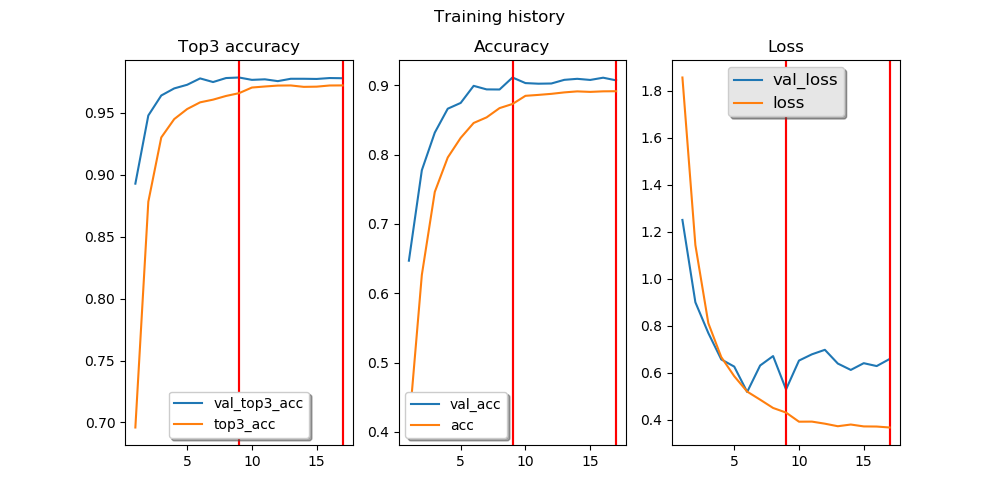

Normalized confusion matrix


<IPython.core.display.Javascript object>


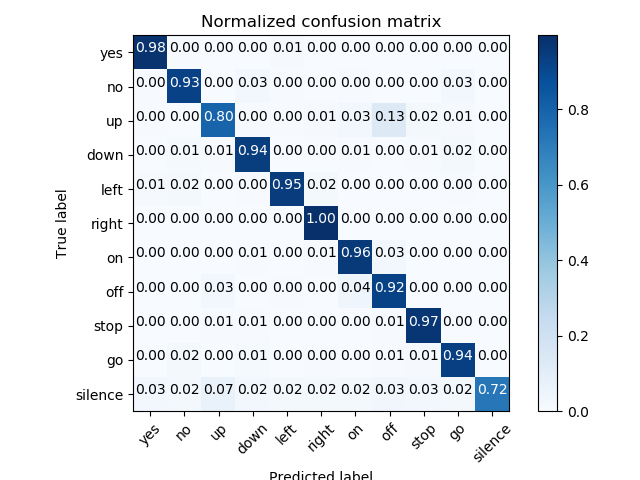

5852/5852 [==============================] - 0s 77us/step
Precision:  89.94 %
Wall time: 2min 15s


In [9]:
%%time
name = 'model1'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.model1(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/3
52848/52848 [==============================] - 9s 177us/step - loss: 1.3743 - acc: 0.5361 - top3_acc: 0.8179 - val_loss: 1.3771 - val_acc: 0.5946 - val_top3_acc: 0.9149
Epoch 2/3
52848/52848 [==============================] - 8s 150us/step - loss: 0.7247 - acc: 0.7671 - top3_acc: 0.9421 - val_loss: 1.0948 - val_acc: 0.7891 - val_top3_acc: 0.9476
Epoch 3/3
52848/52848 [==============================] - 8s 150us/step - loss: 0.5557 - acc: 0.8302 - top3_acc: 0.9580 - val_loss: 0.6719 - val_acc: 0.8705 - val_top3_acc: 0.9733
Using optimizer number 1
Train on 52848 samples, validate on 6813 samples
Epoch 1/3
52848/52848 [==============================] - 8s 159us/step - loss: 0.4868 - acc: 0.8495 - top3_acc: 0.9649 - val_loss: 0.6387 - val_acc: 0.8767 - val_top3_acc: 0.9752
Epoch 2/3
52848/52848 [==============================] - 7s 141us/step - loss: 0.4795 - acc: 0.8535 - top3_acc:

<IPython.core.display.Javascript object>


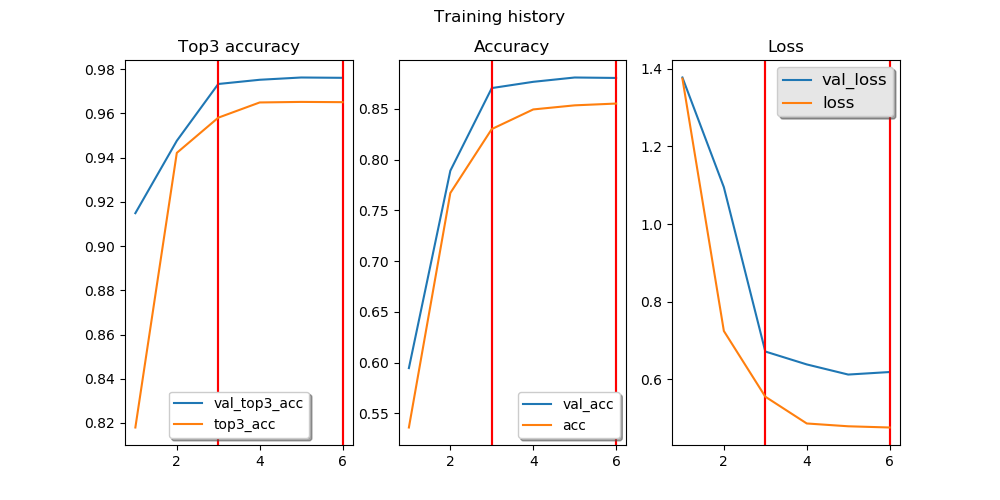

Normalized confusion matrix


<IPython.core.display.Javascript object>


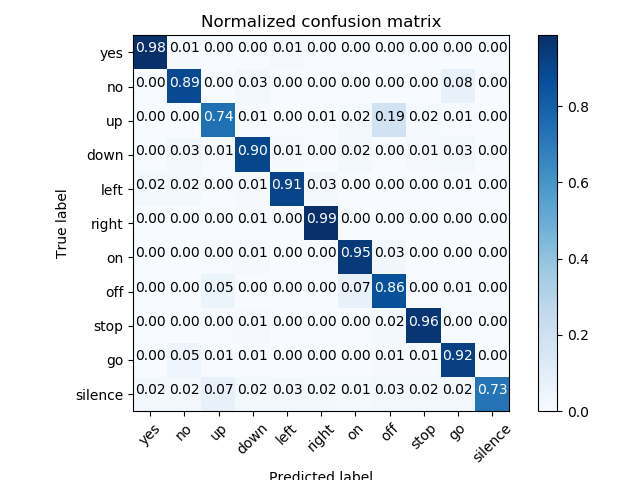

5852/5852 [==============================] - 0s 78us/step
Precision:  87.59 %
Wall time: 1min 25s


In [10]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.model1(inputData,inputLabel)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=3,#epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

## Model2

model2
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 16s 533us/step - loss: 2.0115 - acc: 0.2917 - top3_acc: 0.5614 - val_loss: 1.6738 - val_acc: 0.4298 - val_top3_acc: 0.7365
Epoch 2/20
30881/30881 [==============================] - 14s 456us/step - loss: 1.4815 - acc: 0.4885 - top3_acc: 0.7871 - val_loss: 1.0778 - val_acc: 0.6501 - val_top3_acc: 0.8842
Epoch 3/20
30881/30881 [==============================] - 14s 457us/step - loss: 1.1726 - acc: 0.6082 - top3_acc: 0.8652 - val_loss: 0.7975 - val_acc: 0.7492 - val_top3_acc: 0.9307
Epoch 4/20
30881/30881 [==============================] - 14s 460us/step - loss: 0.9586 - acc: 0.6845 - top3_acc: 0.9030 - val_loss: 0.6523 - val_acc: 0.8002 - val_top3_acc: 0.9473
Epoch 5/20
30881/30881 [==============================] - 14s 457us/step - loss: 0.8091 - acc: 0.7360 - top3_acc: 0.9269 - val_loss: 0.5063 - val_acc: 0.8429 - val_top3_acc: 0.9624
Epoch 6/20
308

<IPython.core.display.Javascript object>


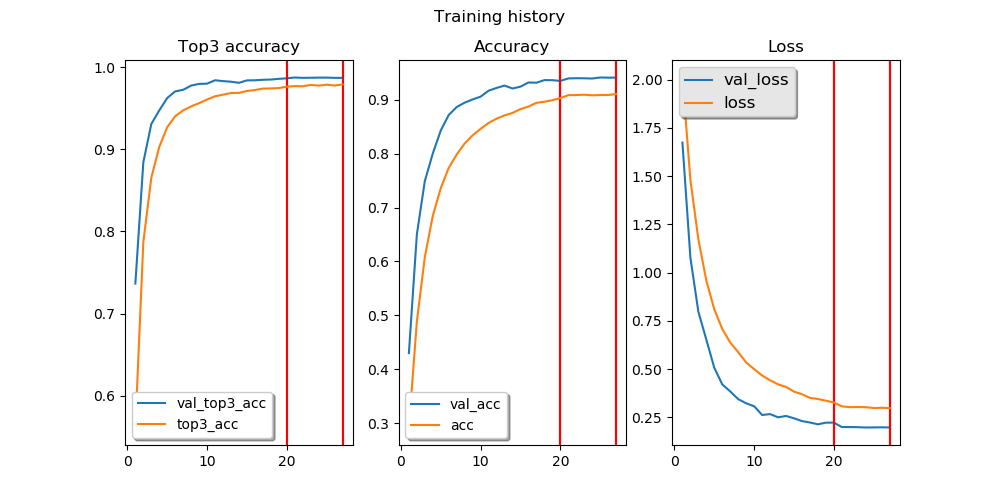

Normalized confusion matrix


<IPython.core.display.Javascript object>


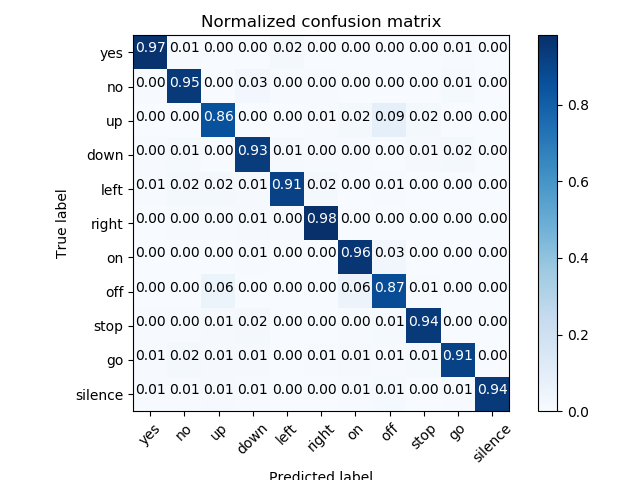

5852/5852 [==============================] - 1s 163us/step
Precision:  92.98 %
Wall time: 7min 46s


In [11]:
%%time
name = 'model2'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.model2(inputData,inputLabel, baseDim = 40)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))


functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs


table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 25s 471us/step - loss: 1.8680 - acc: 0.3609 - top3_acc: 0.6288 - val_loss: 1.5465 - val_acc: 0.4858 - val_top3_acc: 0.7925
Epoch 2/20
52848/52848 [==============================] - 22s 419us/step - loss: 1.2254 - acc: 0.5918 - top3_acc: 0.8453 - val_loss: 0.8136 - val_acc: 0.7439 - val_top3_acc: 0.9293
Epoch 3/20
52848/52848 [==============================] - 22s 419us/step - loss: 0.8967 - acc: 0.7091 - top3_acc: 0.9125 - val_loss: 0.5479 - val_acc: 0.8402 - val_top3_acc: 0.9605
Epoch 4/20
52848/52848 [==============================] - 22s 419us/step - loss: 0.7066 - acc: 0.7756 - top3_acc: 0.9400 - val_loss: 0.4236 - val_acc: 0.8760 - val_top3_acc: 0.9718
Epoch 5/20
52848/52848 [==============================] - 22s 419us/step - loss: 0.5887 - acc: 0.8151 - top3_acc: 0.9536 - val_loss: 0.3948 - val_acc: 0.8836 - val_top3_acc: 0.9

<IPython.core.display.Javascript object>


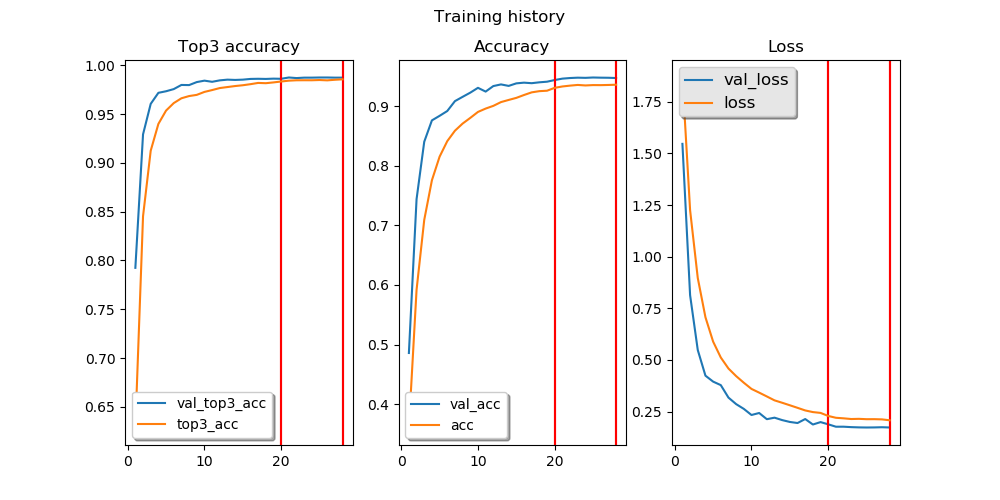

Normalized confusion matrix


<IPython.core.display.Javascript object>


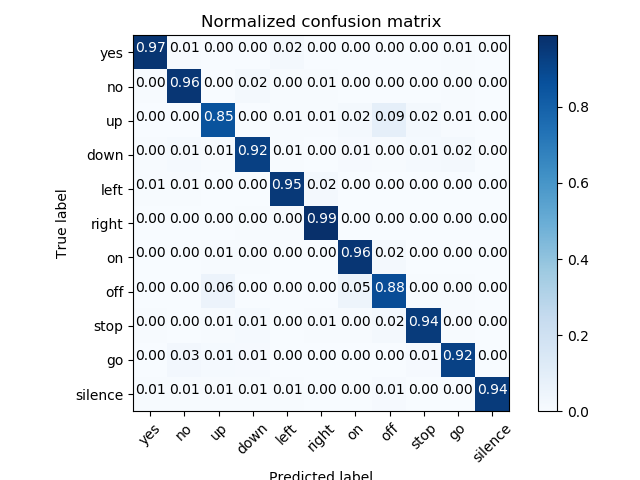

5852/5852 [==============================] - 1s 167us/step
Precision:  93.66 %
Wall time: 11min 44s


In [12]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.model2(inputData,inputLabel, baseDim = 40 )

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

## TinyDarknet

tinyDarknet
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 20s 648us/step - loss: 2.4468 - acc: 0.4753 - top3_acc: 0.7280 - val_loss: 3.8620 - val_acc: 0.5192 - val_top3_acc: 0.8421
Epoch 2/20
30881/30881 [==============================] - 15s 492us/step - loss: 0.8860 - acc: 0.7591 - top3_acc: 0.9362 - val_loss: 4.6830 - val_acc: 0.5391 - val_top3_acc: 0.7826
Epoch 3/20
30881/30881 [==============================] - 15s 491us/step - loss: 0.6713 - acc: 0.8225 - top3_acc: 0.9553 - val_loss: 2.0394 - val_acc: 0.7552 - val_top3_acc: 0.9203
Epoch 4/20
30881/30881 [==============================] - 15s 492us/step - loss: 0.5461 - acc: 0.8606 - top3_acc: 0.9661 - val_loss: 0.5949 - val_acc: 0.8619 - val_top3_acc: 0.9726
Epoch 5/20
30881/30881 [==============================] - 15s 492us/step - loss: 0.4972 - acc: 0.8713 - top3_acc: 0.9686 - val_loss: 1.0445 - val_acc: 0.8429 - val_top3_acc: 0.9539
Epoch 6/2

<IPython.core.display.Javascript object>


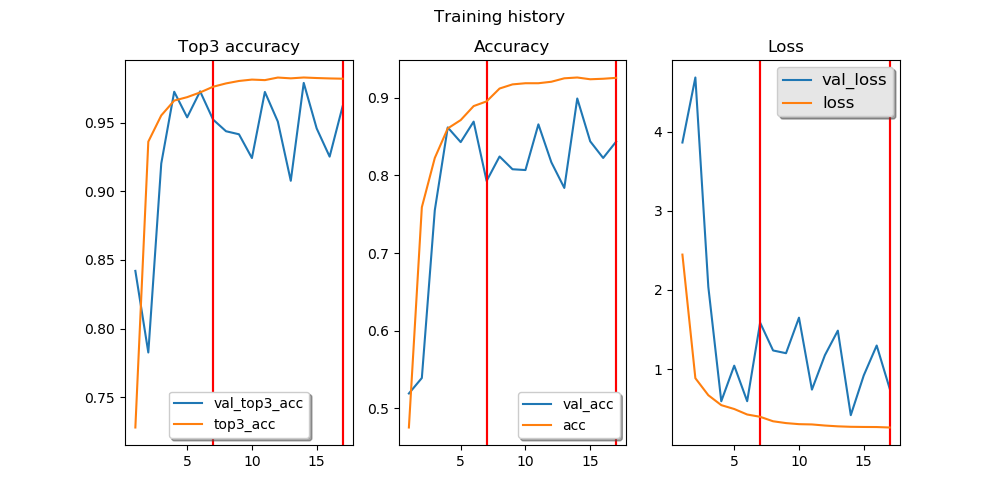

Normalized confusion matrix


<IPython.core.display.Javascript object>


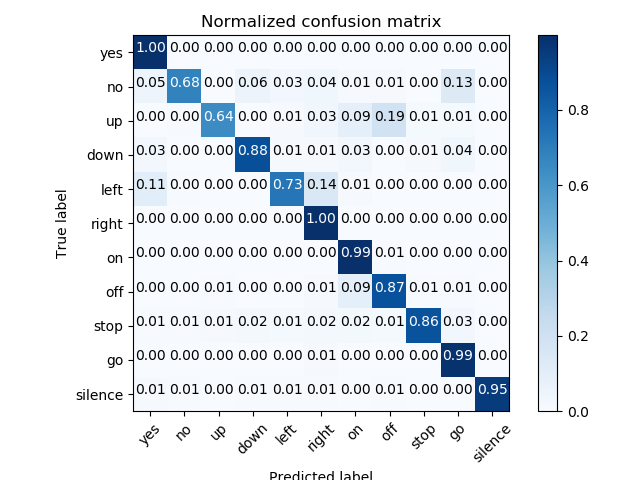

5852/5852 [==============================] - 1s 155us/step
Precision:  84.45 %
Wall time: 5min 35s


In [13]:
%%time
name = 'tinyDarknet'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.3)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 27s 506us/step - loss: 2.0825 - acc: 0.5543 - top3_acc: 0.7817 - val_loss: 0.6709 - val_acc: 0.8264 - val_top3_acc: 0.9598
Epoch 2/20
52848/52848 [==============================] - 21s 405us/step - loss: 0.6084 - acc: 0.8375 - top3_acc: 0.9601 - val_loss: 0.3941 - val_acc: 0.9027 - val_top3_acc: 0.9780
Epoch 3/20
52848/52848 [==============================] - 21s 405us/step - loss: 0.4489 - acc: 0.8810 - top3_acc: 0.9717 - val_loss: 0.3670 - val_acc: 0.9042 - val_top3_acc: 0.9815
Epoch 4/20
52848/52848 [==============================] - 21s 405us/step - loss: 0.3765 - acc: 0.9006 - top3_acc: 0.9776 - val_loss: 0.3079 - val_acc: 0.9244 - val_top3_acc: 0.9818
Epoch 5/20
52848/52848 [==============================] - 21s 405us/step - loss: 0.3339 - acc: 0.9125 - top3_acc: 0.9806 - val_loss: 0.2943 - val_acc: 0.9240 - val_top3_acc: 0.9

<IPython.core.display.Javascript object>


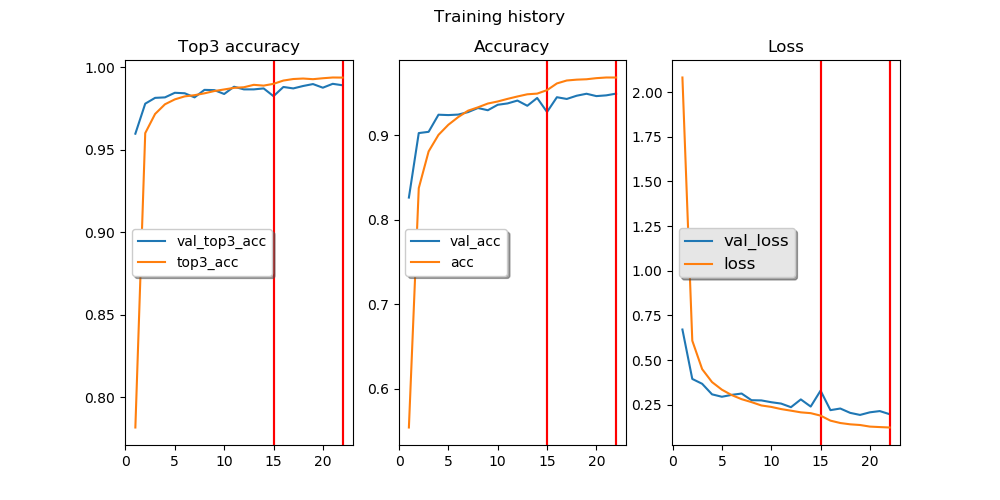

Normalized confusion matrix


<IPython.core.display.Javascript object>


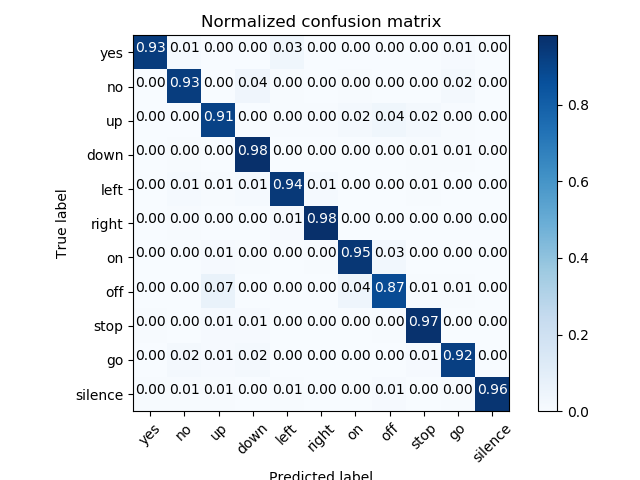

5852/5852 [==============================] - 1s 159us/step
Precision:  94.14 %
Wall time: 9min 19s


In [14]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.3)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

# Inception

## Single input

SiSoInc
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 7s 239us/step - loss: 1.4026 - acc: 0.5228 - top3_acc: 0.7921 - val_loss: 0.8053 - val_acc: 0.7490 - val_top3_acc: 0.9376
Epoch 2/20
30881/30881 [==============================] - 4s 131us/step - loss: 0.7950 - acc: 0.7431 - top3_acc: 0.9336 - val_loss: 0.5318 - val_acc: 0.8252 - val_top3_acc: 0.9611
Epoch 3/20
30881/30881 [==============================] - 4s 131us/step - loss: 0.6365 - acc: 0.7990 - top3_acc: 0.9488 - val_loss: 0.4431 - val_acc: 0.8563 - val_top3_acc: 0.9693
Epoch 4/20
30881/30881 [==============================] - 4s 132us/step - loss: 0.5482 - acc: 0.8268 - top3_acc: 0.9600 - val_loss: 0.3912 - val_acc: 0.8691 - val_top3_acc: 0.9724
Epoch 5/20
30881/30881 [==============================] - 4s 131us/step - loss: 0.4913 - acc: 0.8475 - top3_acc: 0.9631 - val_loss: 0.3768 - val_acc: 0.8820 - val_top3_acc: 0.9745
Epoch 6/20
30881/3

<IPython.core.display.Javascript object>


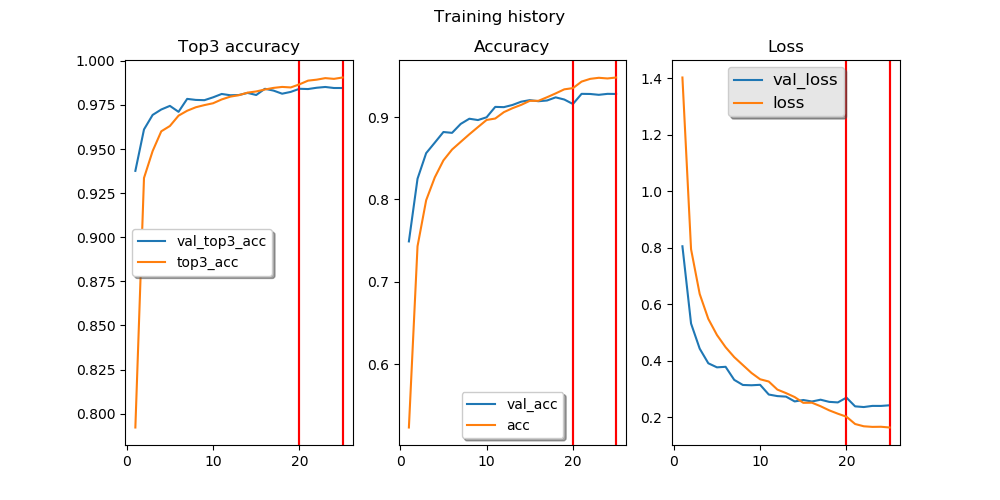

Normalized confusion matrix


<IPython.core.display.Javascript object>


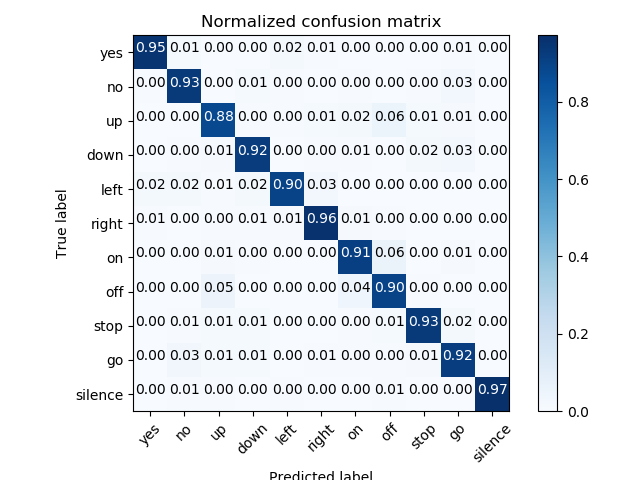

5852/5852 [==============================] - 0s 79us/step
Precision:  92.7 %
Wall time: 2min 20s


In [15]:
%%time
name = 'SiSoInc'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.SiSoInception(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 9s 172us/step - loss: 1.2583 - acc: 0.5883 - top3_acc: 0.8208 - val_loss: 0.6767 - val_acc: 0.7820 - val_top3_acc: 0.9451
Epoch 2/20
52848/52848 [==============================] - 5s 96us/step - loss: 0.7075 - acc: 0.7756 - top3_acc: 0.9402 - val_loss: 0.4923 - val_acc: 0.8394 - val_top3_acc: 0.9636
Epoch 3/20
52848/52848 [==============================] - 5s 96us/step - loss: 0.5452 - acc: 0.8281 - top3_acc: 0.9576 - val_loss: 0.4117 - val_acc: 0.8641 - val_top3_acc: 0.9706
Epoch 4/20
52848/52848 [==============================] - 5s 96us/step - loss: 0.4704 - acc: 0.8528 - top3_acc: 0.9649 - val_loss: 0.3863 - val_acc: 0.8754 - val_top3_acc: 0.9742
Epoch 5/20
52848/52848 [==============================] - 5s 95us/step - loss: 0.4251 - acc: 0.8665 - top3_acc: 0.9697 - val_loss: 0.3343 - val_acc: 0.8912 - val_top3_acc: 0.9768
Epoch

<IPython.core.display.Javascript object>


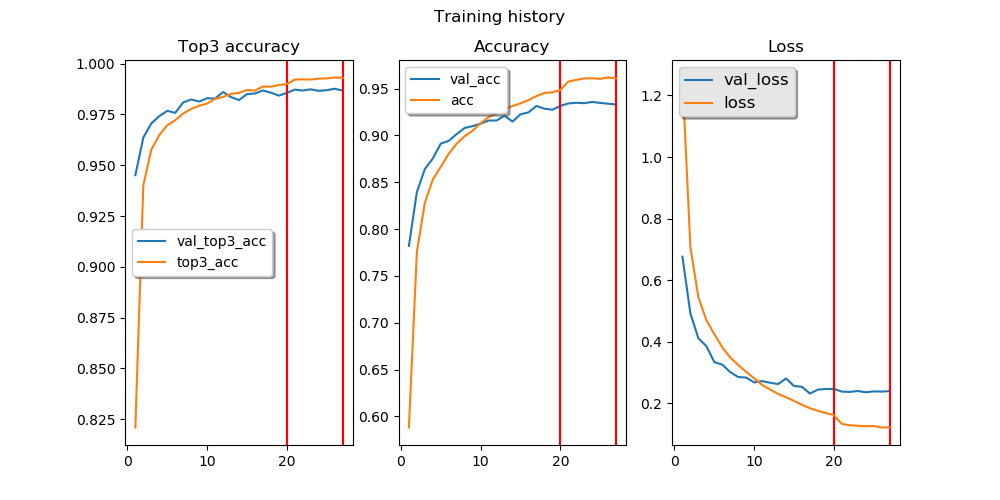

Normalized confusion matrix


<IPython.core.display.Javascript object>


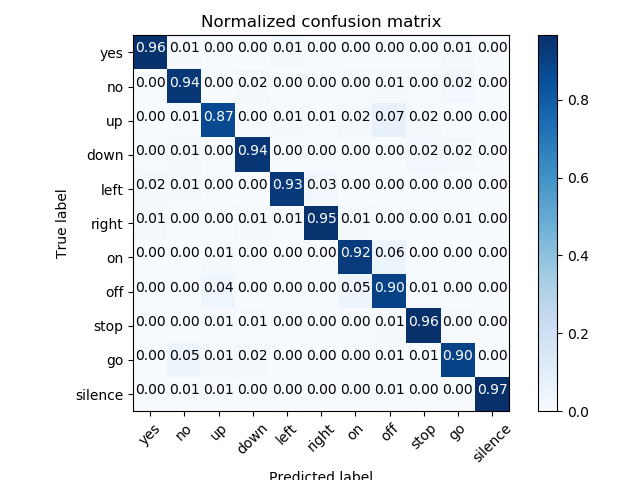

5852/5852 [==============================] - 0s 82us/step
Precision:  93.05 %
Wall time: 2min 57s


In [16]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.SiSoInception(inputData,inputLabel, dropout = 0.5)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

# Creating dataset

In [17]:
#choose which dictionary to use
choice =    'mfcc'
useDelta =  True

data = {}
    
selected = 0

if choice == 'mfcc':
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/mfccDictDD'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/mfccDict'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #loading in usedDict of the mfcc dict
        with open(name, 'rb') as f: 
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

elif choice == 'logfilter':
    #retrieving of used values for the computation of mfcc
    with open('variables/lfValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/logfiltDictDD'+functions.getName(index)+'[nF='+str(values[selected][0])+' wL='+str(values[selected][1])+' wS='+str(values[selected][2])+'].pkl'
        else:
            name = 'variables/logfiltDict'+functions.getName(index)+'[nF='+str(values[selected][0])+' wL='+str(values[selected][1])+' wS='+str(values[selected][2])+'].pkl'
        #saving in usedDict of the logfilter dict
        with open(name, 'rb') as f:  
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

Loaded variables/mfccDictDDTrain[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictDDTest[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictDDValidation[nC=14 wL=0.025 wS=0.01].pkl
Loaded variables/mfccDictDDAugmentedTrain[nC=14 wL=0.025 wS=0.01].pkl


In [18]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#selecting the subset of words to predict
usedLabels = words

usedLabels.append('silence')

unknownLabels = list(data['Train'].keys())
for key in usedLabels:
    try:
        unknownLabels.remove(key)
    except:
        print(key, ' not in used')

In [19]:
%%time
#divding between train and test with also scaling data
functions.train_test_creator(
    data,
    usedLabels,
    unknownLabels,
    with_unknown = False,
    scalerType = 'robust',
    depth = (len(data['Train'][words[0]].shape)-3)*2 + 1,
    unknown_percentage = 0.3)

print()


Wall time: 52.4 s


# Import data

In [20]:
dataset, labels = functions.load_dataset()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

## Fitting variables

In [21]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.8 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 20
epochSGD = 20

epochs = [epoch, epochSGD]

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.001, decay=0.001/epochSGD, momentum=0.9, nesterov=True)

optimizers = [adam, sgd]

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

titles = ['Adam History', 'SGD History']

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

esCallBack = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto', baseline=None)

# Sequential Models

## Model1

model1
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 11s 361us/step - loss: 1.8928 - acc: 0.3769 - top3_acc: 0.6809 - val_loss: 1.3453 - val_acc: 0.6354 - val_top3_acc: 0.8904
Epoch 2/20
30881/30881 [==============================] - 7s 225us/step - loss: 1.0935 - acc: 0.6422 - top3_acc: 0.9000 - val_loss: 1.0126 - val_acc: 0.7699 - val_top3_acc: 0.9464
Epoch 3/20
30881/30881 [==============================] - 7s 225us/step - loss: 0.7376 - acc: 0.7720 - top3_acc: 0.9423 - val_loss: 0.7489 - val_acc: 0.8685 - val_top3_acc: 0.9684
Epoch 4/20
30881/30881 [==============================] - 7s 225us/step - loss: 0.5837 - acc: 0.8285 - top3_acc: 0.9542 - val_loss: 0.6619 - val_acc: 0.8936 - val_top3_acc: 0.9727
Epoch 5/20
30881/30881 [==============================] - 7s 225us/step - loss: 0.5033 - acc: 0.8524 - top3_acc: 0.9598 - val_loss: 0.7274 - val_acc: 0.8929 - val_top3_acc: 0.9740
Epoch 6/20
30881/3

<IPython.core.display.Javascript object>


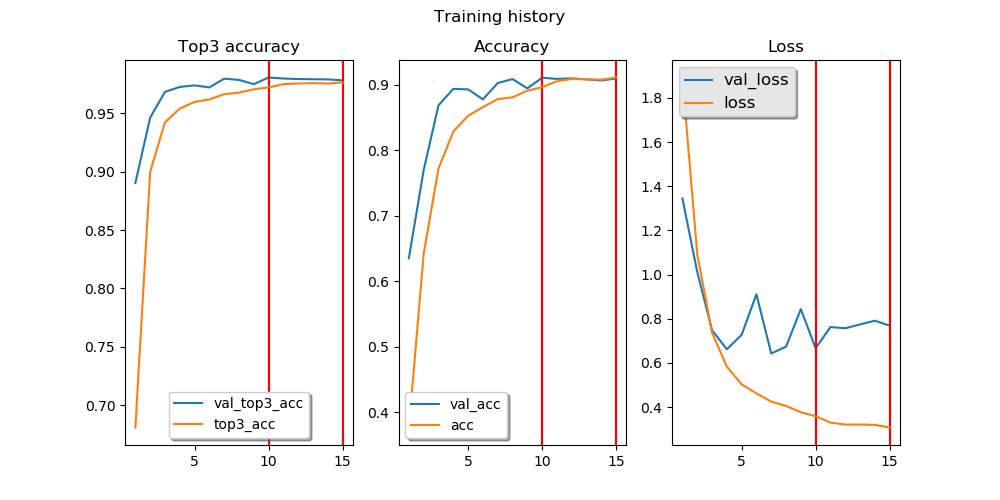

Normalized confusion matrix


<IPython.core.display.Javascript object>


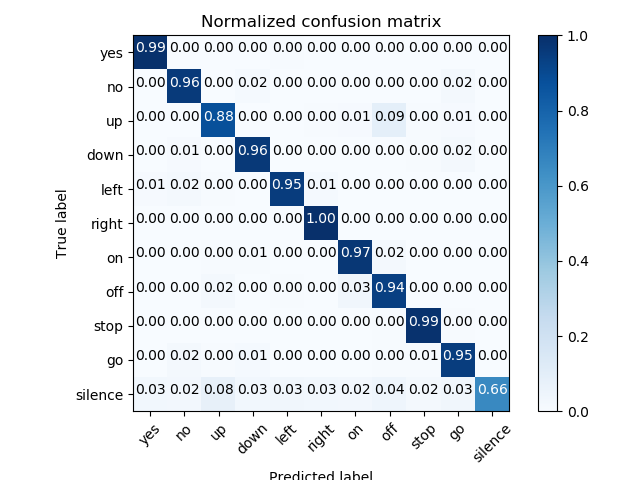

5852/5852 [==============================] - 1s 119us/step
Precision:  90.09 %
Wall time: 2min 54s


In [22]:
%%time
name = 'model1'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.model1(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/3
52848/52848 [==============================] - 13s 240us/step - loss: 1.3576 - acc: 0.5430 - top3_acc: 0.8154 - val_loss: 1.8027 - val_acc: 0.7638 - val_top3_acc: 0.9000
Epoch 2/3
52848/52848 [==============================] - 9s 175us/step - loss: 0.6064 - acc: 0.8135 - top3_acc: 0.9542 - val_loss: 1.8487 - val_acc: 0.7860 - val_top3_acc: 0.8892
Epoch 3/3
52848/52848 [==============================] - 9s 175us/step - loss: 0.4506 - acc: 0.8676 - top3_acc: 0.9664 - val_loss: 1.6893 - val_acc: 0.8272 - val_top3_acc: 0.8939
Using optimizer number 1
Train on 52848 samples, validate on 6813 samples
Epoch 1/3
52848/52848 [==============================] - 12s 223us/step - loss: 0.3938 - acc: 0.8841 - top3_acc: 0.9703 - val_loss: 1.6368 - val_acc: 0.8217 - val_top3_acc: 0.8965
Epoch 2/3
52848/52848 [==============================] - 9s 166us/step - loss: 0.3921 - acc: 0.8852 - top3_ac

<IPython.core.display.Javascript object>


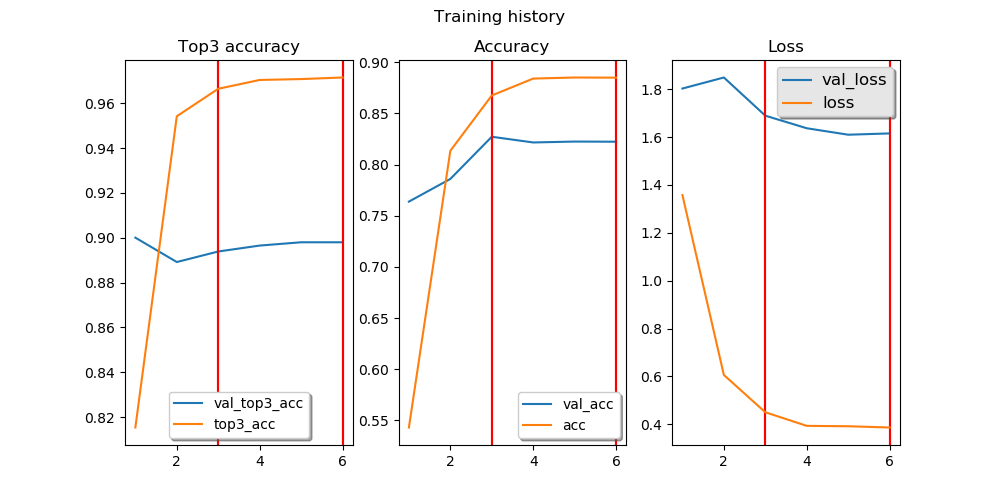

Normalized confusion matrix


<IPython.core.display.Javascript object>


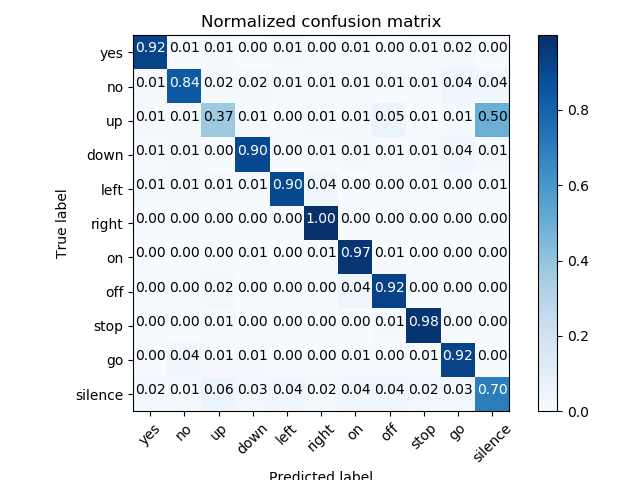

5852/5852 [==============================] - 1s 126us/step
Precision:  80.59 %
Wall time: 2min 5s


In [23]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.model1(inputData,inputLabel)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=3,#epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

## Model2

model2
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 19s 625us/step - loss: 1.8975 - acc: 0.3426 - top3_acc: 0.6167 - val_loss: 1.3806 - val_acc: 0.5208 - val_top3_acc: 0.8292
Epoch 2/20
30881/30881 [==============================] - 15s 501us/step - loss: 1.1061 - acc: 0.6184 - top3_acc: 0.8923 - val_loss: 0.8238 - val_acc: 0.7088 - val_top3_acc: 0.9356
Epoch 3/20
30881/30881 [==============================] - 15s 501us/step - loss: 0.7575 - acc: 0.7488 - top3_acc: 0.9439 - val_loss: 0.4370 - val_acc: 0.8700 - val_top3_acc: 0.9790
Epoch 4/20
30881/30881 [==============================] - 16s 502us/step - loss: 0.6349 - acc: 0.7909 - top3_acc: 0.9562 - val_loss: 0.3649 - val_acc: 0.8868 - val_top3_acc: 0.9814
Epoch 5/20
30881/30881 [==============================] - 15s 501us/step - loss: 0.5307 - acc: 0.8343 - top3_acc: 0.9616 - val_loss: 0.3325 - val_acc: 0.9024 - val_top3_acc: 0.9797
Epoch 6/20
308

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


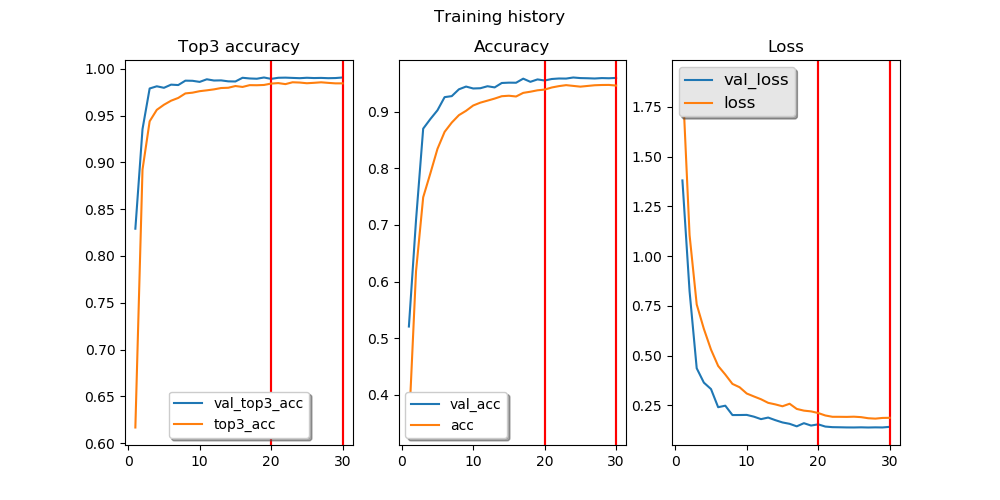

Normalized confusion matrix


<IPython.core.display.Javascript object>


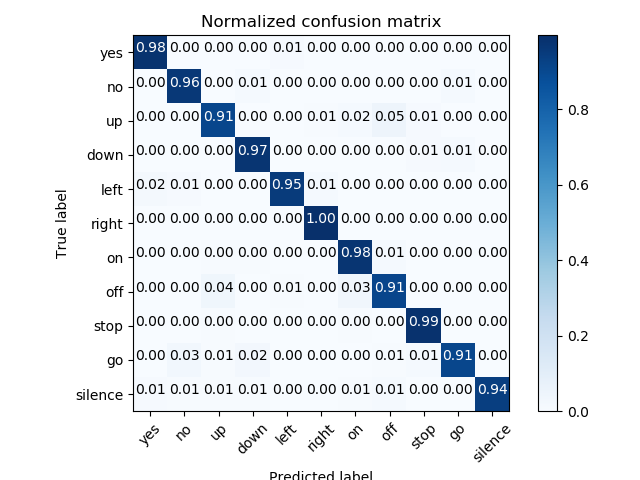

5852/5852 [==============================] - 1s 206us/step
Precision:  95.28 %
Wall time: 9min 34s


In [24]:
%%time
name = 'model2'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.model2(inputData,inputLabel, baseDim = 40)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))


functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs


table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 27s 516us/step - loss: 1.8547 - acc: 0.3542 - top3_acc: 0.6268 - val_loss: 1.5136 - val_acc: 0.4779 - val_top3_acc: 0.7883
Epoch 2/20
52848/52848 [==============================] - 23s 439us/step - loss: 1.0074 - acc: 0.6634 - top3_acc: 0.9061 - val_loss: 1.0617 - val_acc: 0.6674 - val_top3_acc: 0.8901
Epoch 3/20
52848/52848 [==============================] - 23s 439us/step - loss: 0.6513 - acc: 0.7930 - top3_acc: 0.9513 - val_loss: 0.3814 - val_acc: 0.8804 - val_top3_acc: 0.9737
Epoch 4/20
52848/52848 [==============================] - 23s 439us/step - loss: 0.5061 - acc: 0.8435 - top3_acc: 0.9632 - val_loss: 0.3857 - val_acc: 0.8920 - val_top3_acc: 0.9746
Epoch 5/20
52848/52848 [==============================] - 23s 439us/step - loss: 0.4170 - acc: 0.8757 - top3_acc: 0.9694 - val_loss: 0.2658 - val_acc: 0.9256 - val_top3_acc: 0.9

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


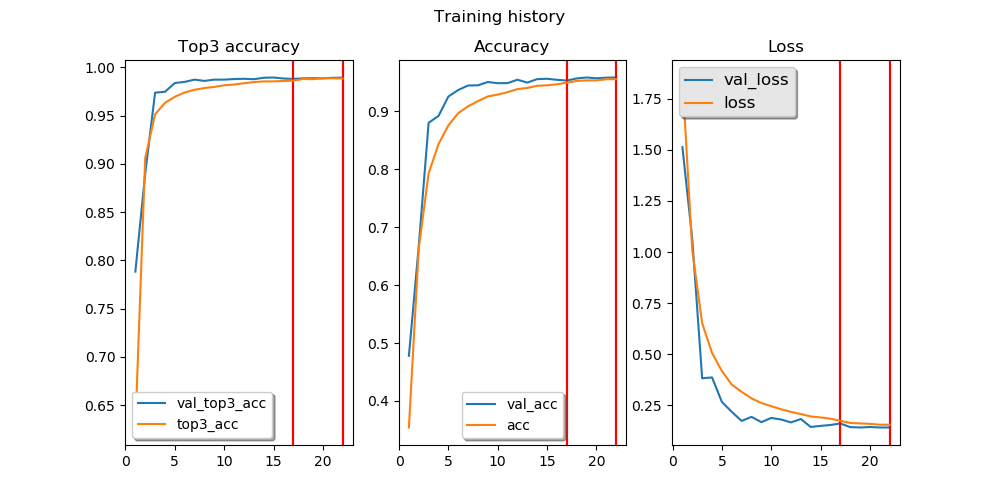

Normalized confusion matrix


<IPython.core.display.Javascript object>


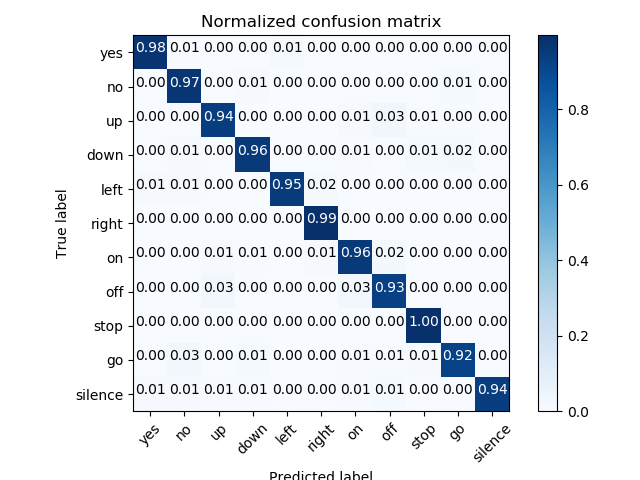

5852/5852 [==============================] - 1s 211us/step
Precision:  95.71 %
Wall time: 10min 29s


In [25]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.model2(inputData,inputLabel, baseDim = 40 )

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

## TinyDarknet

tinyDarknet
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 23s 758us/step - loss: 2.4854 - acc: 0.5075 - top3_acc: 0.7664 - val_loss: 1.3822 - val_acc: 0.7613 - val_top3_acc: 0.9574
Epoch 2/20
30881/30881 [==============================] - 16s 526us/step - loss: 0.6895 - acc: 0.8318 - top3_acc: 0.9609 - val_loss: 2.9467 - val_acc: 0.6821 - val_top3_acc: 0.9451
Epoch 3/20
30881/30881 [==============================] - 16s 526us/step - loss: 0.5205 - acc: 0.8738 - top3_acc: 0.9670 - val_loss: 1.0412 - val_acc: 0.8428 - val_top3_acc: 0.9549
Epoch 4/20
30881/30881 [==============================] - 16s 526us/step - loss: 0.4197 - acc: 0.8990 - top3_acc: 0.9728 - val_loss: 0.6625 - val_acc: 0.8774 - val_top3_acc: 0.9680
Epoch 5/20
30881/30881 [==============================] - 16s 526us/step - loss: 0.3954 - acc: 0.9081 - top3_acc: 0.9759 - val_loss: 0.7178 - val_acc: 0.8680 - val_top3_acc: 0.9655
Epoch 6/2

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


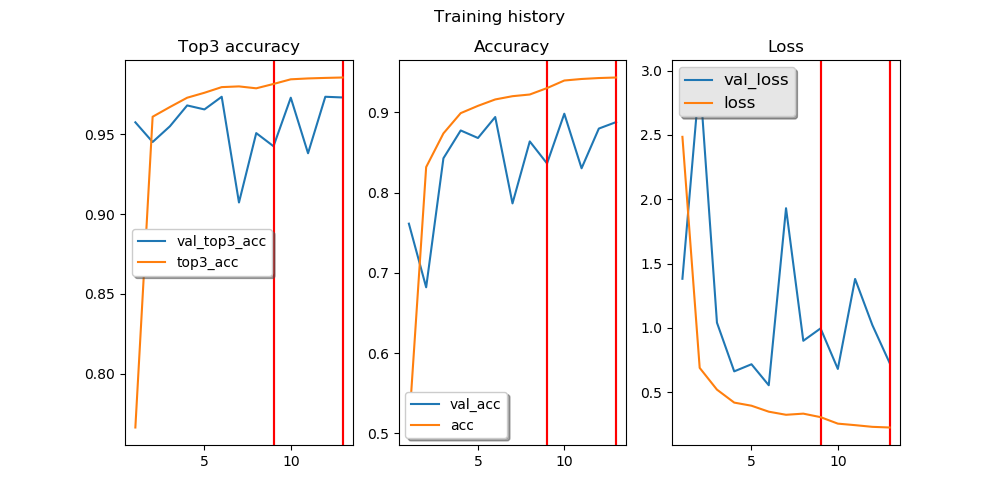

Normalized confusion matrix


<IPython.core.display.Javascript object>


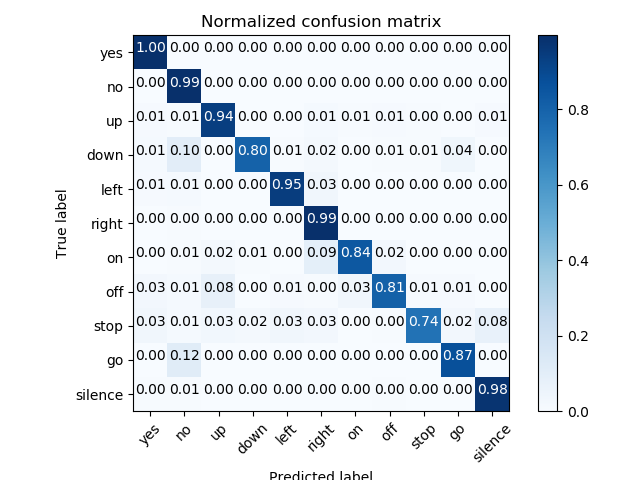

5852/5852 [==============================] - 1s 195us/step
Precision:  89.08 %
Wall time: 5min 24s


In [26]:
%%time
name = 'tinyDarknet'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.3)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 30s 567us/step - loss: 2.3342 - acc: 0.4906 - top3_acc: 0.7281 - val_loss: 0.6052 - val_acc: 0.8518 - val_top3_acc: 0.9720
Epoch 2/20
52848/52848 [==============================] - 23s 429us/step - loss: 0.5466 - acc: 0.8634 - top3_acc: 0.9671 - val_loss: 0.3010 - val_acc: 0.9259 - val_top3_acc: 0.9847
Epoch 3/20
52848/52848 [==============================] - 23s 429us/step - loss: 0.3806 - acc: 0.9031 - top3_acc: 0.9767 - val_loss: 0.2746 - val_acc: 0.9329 - val_top3_acc: 0.9843
Epoch 4/20
52848/52848 [==============================] - 23s 429us/step - loss: 0.3232 - acc: 0.9178 - top3_acc: 0.9802 - val_loss: 0.2799 - val_acc: 0.9345 - val_top3_acc: 0.9827
Epoch 5/20
52848/52848 [==============================] - 23s 429us/step - loss: 0.2880 - acc: 0.9273 - top3_acc: 0.9822 - val_loss: 0.2271 - val_acc: 0.9469 - val_top3_acc: 0.9

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


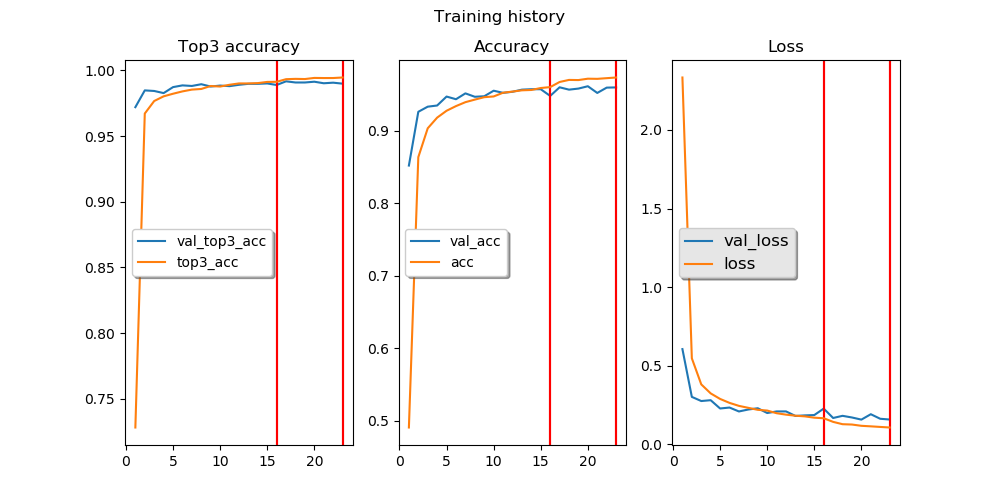

Normalized confusion matrix


<IPython.core.display.Javascript object>


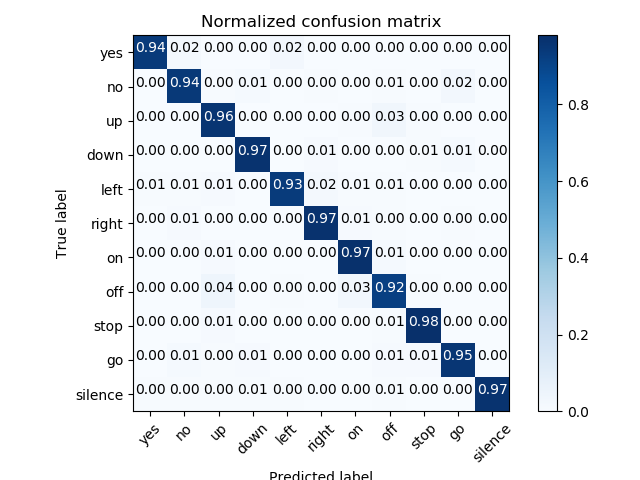

5852/5852 [==============================] - 1s 206us/step
Precision:  95.57 %
Wall time: 10min 38s


In [27]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.3)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

# Inception

## Single input

SiSoInc
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 10s 335us/step - loss: 1.0729 - acc: 0.6330 - top3_acc: 0.8538 - val_loss: 0.4235 - val_acc: 0.8702 - val_top3_acc: 0.9692
Epoch 2/20
30881/30881 [==============================] - 5s 171us/step - loss: 0.4978 - acc: 0.8440 - top3_acc: 0.9626 - val_loss: 0.2916 - val_acc: 0.9124 - val_top3_acc: 0.9805
Epoch 3/20
30881/30881 [==============================] - 5s 172us/step - loss: 0.3872 - acc: 0.8830 - top3_acc: 0.9720 - val_loss: 0.2437 - val_acc: 0.9210 - val_top3_acc: 0.9830
Epoch 4/20
30881/30881 [==============================] - 5s 171us/step - loss: 0.3213 - acc: 0.9039 - top3_acc: 0.9771 - val_loss: 0.2330 - val_acc: 0.9306 - val_top3_acc: 0.9849
Epoch 5/20
30881/30881 [==============================] - 5s 172us/step - loss: 0.2830 - acc: 0.9148 - top3_acc: 0.9801 - val_loss: 0.2000 - val_acc: 0.9392 - val_top3_acc: 0.9866
Epoch 6/20
30881/

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


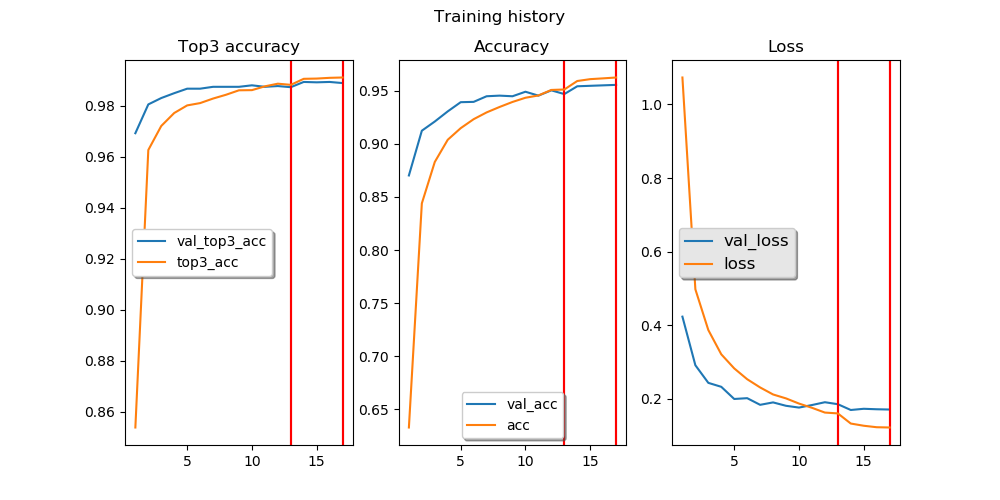

Normalized confusion matrix


<IPython.core.display.Javascript object>


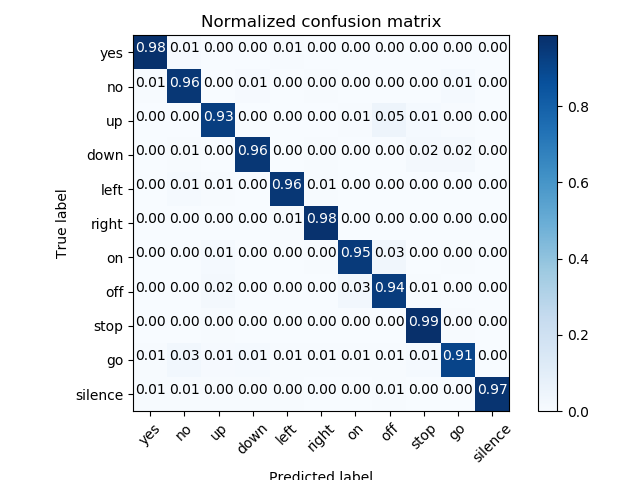

5852/5852 [==============================] - 1s 137us/step
Precision:  95.49 %
Wall time: 2min 45s


In [28]:
%%time
name = 'SiSoInc'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.SiSoInception(inputData,inputLabel)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 12s 223us/step - loss: 0.8267 - acc: 0.7275 - top3_acc: 0.8968 - val_loss: 0.2851 - val_acc: 0.9099 - val_top3_acc: 0.9821
Epoch 2/20
52848/52848 [==============================] - 7s 124us/step - loss: 0.3322 - acc: 0.8997 - top3_acc: 0.9769 - val_loss: 0.2317 - val_acc: 0.9288 - val_top3_acc: 0.9840
Epoch 3/20
52848/52848 [==============================] - 7s 124us/step - loss: 0.2568 - acc: 0.9237 - top3_acc: 0.9817 - val_loss: 0.2027 - val_acc: 0.9344 - val_top3_acc: 0.9858
Epoch 4/20
52848/52848 [==============================] - 7s 124us/step - loss: 0.2135 - acc: 0.9350 - top3_acc: 0.9844 - val_loss: 0.1942 - val_acc: 0.9413 - val_top3_acc: 0.9862
Epoch 5/20
52848/52848 [==============================] - 7s 124us/step - loss: 0.1909 - acc: 0.9428 - top3_acc: 0.9865 - val_loss: 0.1774 - val_acc: 0.9461 - val_top3_acc: 0.9884


C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


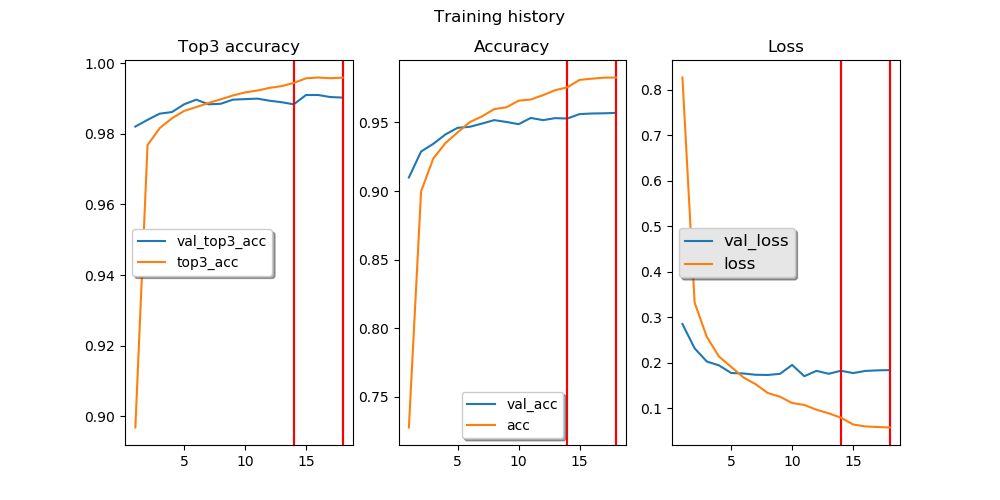

Normalized confusion matrix


<IPython.core.display.Javascript object>


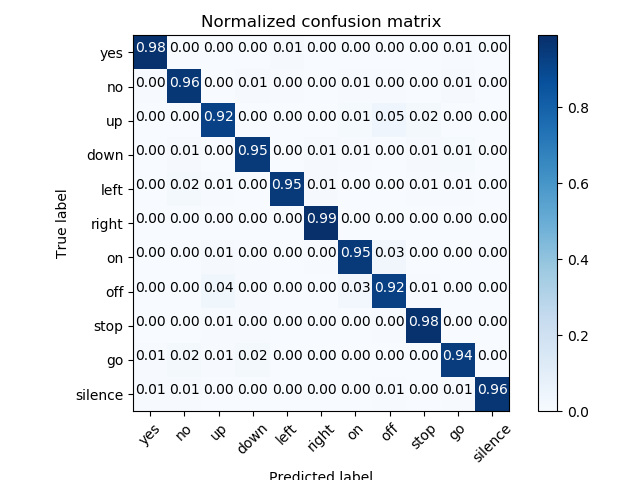

5852/5852 [==============================] - 1s 143us/step
Precision:  95.49 %
Wall time: 3min 17s


In [29]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.SiSoInception(inputData,inputLabel, dropout = 0.5)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

## Multiple input

MiSoInc
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 15s 492us/step - loss: 1.0180 - acc: 0.6504 - top3_acc: 0.8519 - val_loss: 0.3471 - val_acc: 0.8889 - val_top3_acc: 0.9784
Epoch 2/20
30881/30881 [==============================] - 9s 286us/step - loss: 0.3930 - acc: 0.8761 - top3_acc: 0.9717 - val_loss: 0.2850 - val_acc: 0.9113 - val_top3_acc: 0.9811
Epoch 3/20
30881/30881 [==============================] - 9s 285us/step - loss: 0.2990 - acc: 0.9096 - top3_acc: 0.9778 - val_loss: 0.2217 - val_acc: 0.9334 - val_top3_acc: 0.9841
Epoch 4/20
30881/30881 [==============================] - 9s 286us/step - loss: 0.2512 - acc: 0.9223 - top3_acc: 0.9812 - val_loss: 0.2436 - val_acc: 0.9221 - val_top3_acc: 0.9853
Epoch 5/20
30881/30881 [==============================] - 9s 285us/step - loss: 0.2172 - acc: 0.9338 - top3_acc: 0.9836 - val_loss: 0.2027 - val_acc: 0.9354 - val_top3_acc: 0.9875
Epoch 6/20
30881/

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


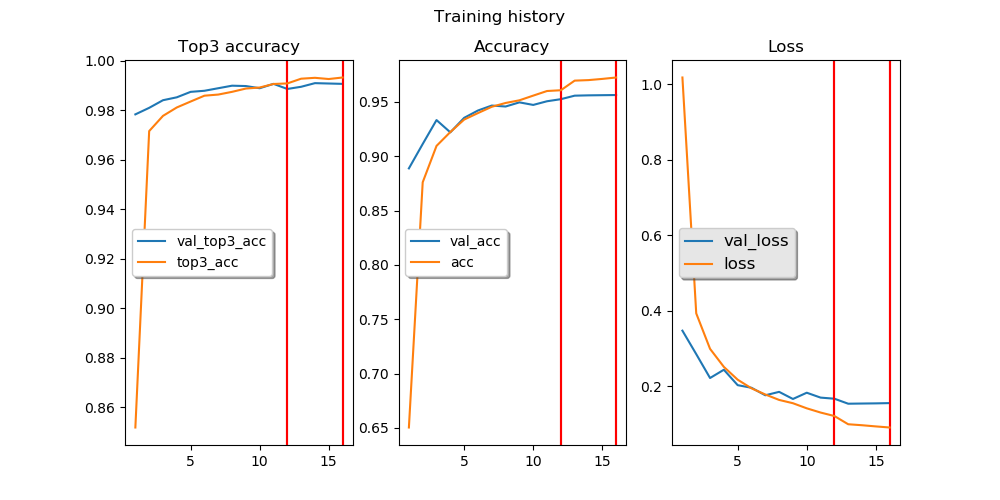

Normalized confusion matrix


<IPython.core.display.Javascript object>


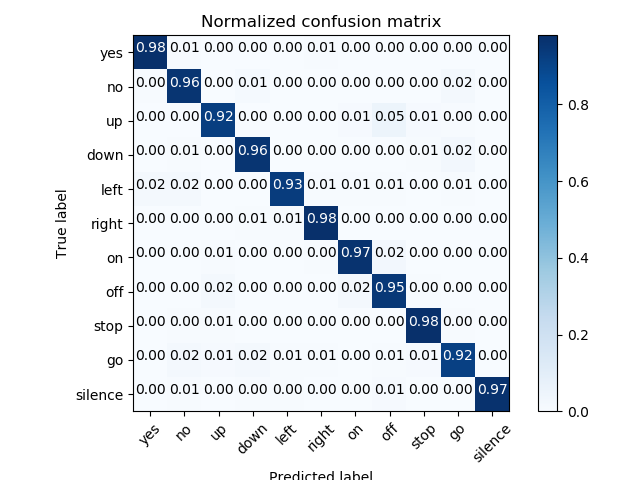

5852/5852 [==============================] - 1s 196us/step
Precision:  95.57 %
Wall time: 4min 12s


In [30]:
%%time
name = 'MiSoInc'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'
inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.MiSoInception(inputData, inputLabel, dropout = 0.4)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData[0].shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData[0].shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 18s 340us/step - loss: 0.8738 - acc: 0.7057 - top3_acc: 0.8935 - val_loss: 0.3177 - val_acc: 0.8992 - val_top3_acc: 0.9795
Epoch 2/20
52848/52848 [==============================] - 12s 226us/step - loss: 0.3397 - acc: 0.8980 - top3_acc: 0.9762 - val_loss: 0.2416 - val_acc: 0.9238 - val_top3_acc: 0.9865
Epoch 3/20
52848/52848 [==============================] - 12s 228us/step - loss: 0.2580 - acc: 0.9224 - top3_acc: 0.9817 - val_loss: 0.1969 - val_acc: 0.9416 - val_top3_acc: 0.9872
Epoch 4/20
52848/52848 [==============================] - 12s 229us/step - loss: 0.2107 - acc: 0.9360 - top3_acc: 0.9853 - val_loss: 0.1977 - val_acc: 0.9404 - val_top3_acc: 0.9880
Epoch 5/20
52848/52848 [==============================] - 12s 228us/step - loss: 0.1845 - acc: 0.9447 - top3_acc: 0.9871 - val_loss: 0.1682 - val_acc: 0.9477 - val_top3_acc: 0.9

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


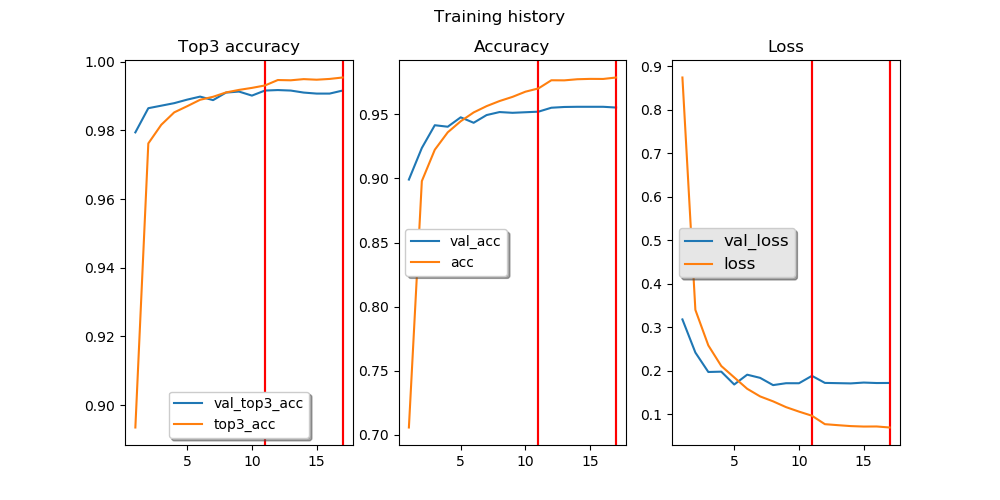

Normalized confusion matrix


<IPython.core.display.Javascript object>


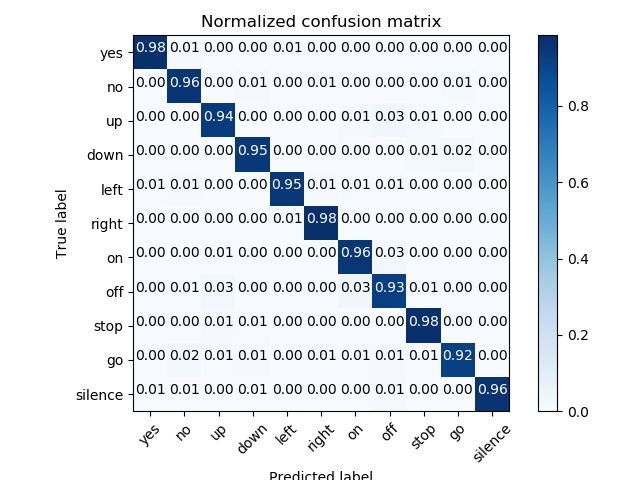

5852/5852 [==============================] - 1s 212us/step
Precision:  95.61 %
Wall time: 5min 27s


In [31]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.MiSoInception(inputData,inputLabel, dropout = 0.4)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData[0].shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs

table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData[0].shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

# Creating dataset

In [32]:
#choose which dictionary to use
choice =    'logfilter'
useDelta =  False

data = {}
    
selected = 0

if choice == 'mfcc':
    #retrieving of used values for the computation of mfcc
    with open('variables/mfccValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/mfccDictDD'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        else:
            name = 'variables/mfccDict'+functions.getName(index)+'[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
        #loading in usedDict of the mfcc dict
        with open(name, 'rb') as f: 
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

elif choice == 'logfilter':
    #retrieving of used values for the computation of mfcc
    with open('variables/lfValues.pkl', 'rb') as f:  
        values = pickle.load(f)
    for index in range(4):
        #name format of the selected data
        if useDelta:
            name = 'variables/logfiltDictDD'+functions.getName(index)+'[nF='+str(values[selected][0])+' wL='+str(values[selected][1])+' wS='+str(values[selected][2])+'].pkl'
        else:
            name = 'variables/logfiltDict'+functions.getName(index)+'[nF='+str(values[selected][0])+' wL='+str(values[selected][1])+' wS='+str(values[selected][2])+'].pkl'
        #saving in usedDict of the logfilter dict
        with open(name, 'rb') as f:  
            data[functions.getName(index)] = pickle.load(f)
        print('Loaded '+name)

Loaded variables/logfiltDictTrain[nF=26 wL=0.025 wS=0.01].pkl
Loaded variables/logfiltDictTest[nF=26 wL=0.025 wS=0.01].pkl
Loaded variables/logfiltDictValidation[nF=26 wL=0.025 wS=0.01].pkl
Loaded variables/logfiltDictAugmentedTrain[nF=26 wL=0.025 wS=0.01].pkl


In [33]:
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

#selecting the subset of words to predict
usedLabels = words

usedLabels.append('silence')

unknownLabels = list(data['Train'].keys())
for key in usedLabels:
    try:
        unknownLabels.remove(key)
    except:
        print(key, ' not in used')

In [34]:
%%time
#divding between train and test with also scaling data
functions.train_test_creator(
    data,
    usedLabels,
    unknownLabels,
    with_unknown = False,
    scalerType = 'robust',
    depth = (len(data['Train'][words[0]].shape)-3)*2 + 1,
    unknown_percentage = 0.3)

print()


Wall time: 17.3 s


# Import data

In [35]:
dataset, labels = functions.load_dataset()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

## Fitting variables

In [36]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.8 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 20
epochSGD = 20

epochs = [epoch, epochSGD]

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epoch, amsgrad=True)
sgd = SGD(lr=0.001, decay=0.001/epochSGD, momentum=0.9, nesterov=True)

optimizers = [adam, sgd]

top3_acc = partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.name = 'top3_acc'

titles = ['Adam History', 'SGD History']

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

esCallBack = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto', baseline=None)

# Sequential Models

## Model2

model2
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 34s 1ms/step - loss: 2.2253 - acc: 0.2413 - top3_acc: 0.4646 - val_loss: 1.8271 - val_acc: 0.4111 - val_top3_acc: 0.6924
Epoch 2/20
30881/30881 [==============================] - 26s 835us/step - loss: 1.7279 - acc: 0.4165 - top3_acc: 0.6973 - val_loss: 1.4172 - val_acc: 0.5401 - val_top3_acc: 0.8399
Epoch 3/20
30881/30881 [==============================] - 26s 836us/step - loss: 1.2786 - acc: 0.5719 - top3_acc: 0.8502 - val_loss: 1.3473 - val_acc: 0.5319 - val_top3_acc: 0.7923
Epoch 4/20
30881/30881 [==============================] - 26s 835us/step - loss: 0.9784 - acc: 0.6726 - top3_acc: 0.9064 - val_loss: 1.1596 - val_acc: 0.5365 - val_top3_acc: 0.8973
Epoch 5/20
30881/30881 [==============================] - 26s 836us/step - loss: 0.8414 - acc: 0.7169 - top3_acc: 0.9289 - val_loss: 0.8796 - val_acc: 0.7202 - val_top3_acc: 0.9030
Epoch 6/20
30881

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


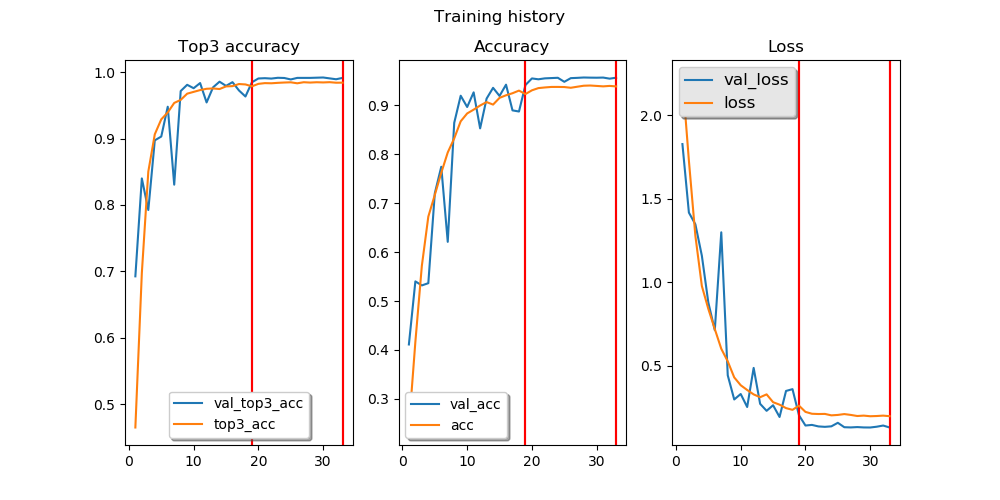

Normalized confusion matrix


<IPython.core.display.Javascript object>


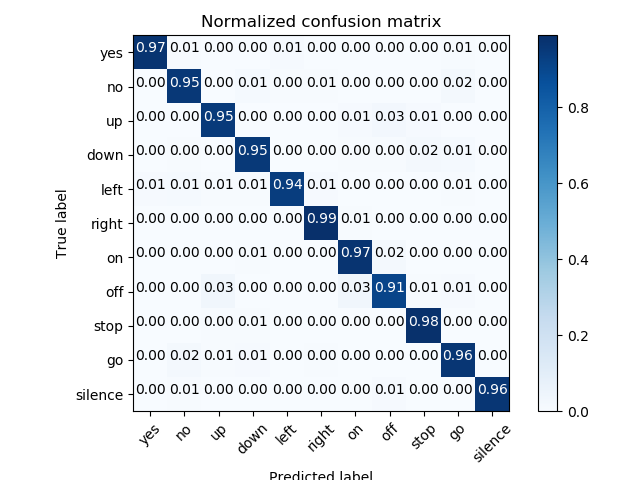

5852/5852 [==============================] - 2s 327us/step
Precision:  95.85 %
Wall time: 17min 18s


In [37]:
%%time
name = 'model2'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.model2(inputData,inputLabel, baseDim = 40)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))


functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs


table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 47s 895us/step - loss: 1.8713 - acc: 0.3616 - top3_acc: 0.6202 - val_loss: 2.9722 - val_acc: 0.1146 - val_top3_acc: 0.3534
Epoch 2/20
52848/52848 [==============================] - 40s 755us/step - loss: 1.1923 - acc: 0.5932 - top3_acc: 0.8642 - val_loss: 0.9440 - val_acc: 0.6929 - val_top3_acc: 0.9047
Epoch 3/20
52848/52848 [==============================] - 40s 754us/step - loss: 0.8379 - acc: 0.7197 - top3_acc: 0.9269 - val_loss: 0.7312 - val_acc: 0.7816 - val_top3_acc: 0.9417
Epoch 4/20
52848/52848 [==============================] - 40s 755us/step - loss: 0.6475 - acc: 0.7897 - top3_acc: 0.9499 - val_loss: 0.5144 - val_acc: 0.8550 - val_top3_acc: 0.9643
Epoch 5/20
52848/52848 [==============================] - 40s 755us/step - loss: 0.5270 - acc: 0.8330 - top3_acc: 0.9606 - val_loss: 0.3981 - val_acc: 0.8786 - val_top3_acc: 0.9

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


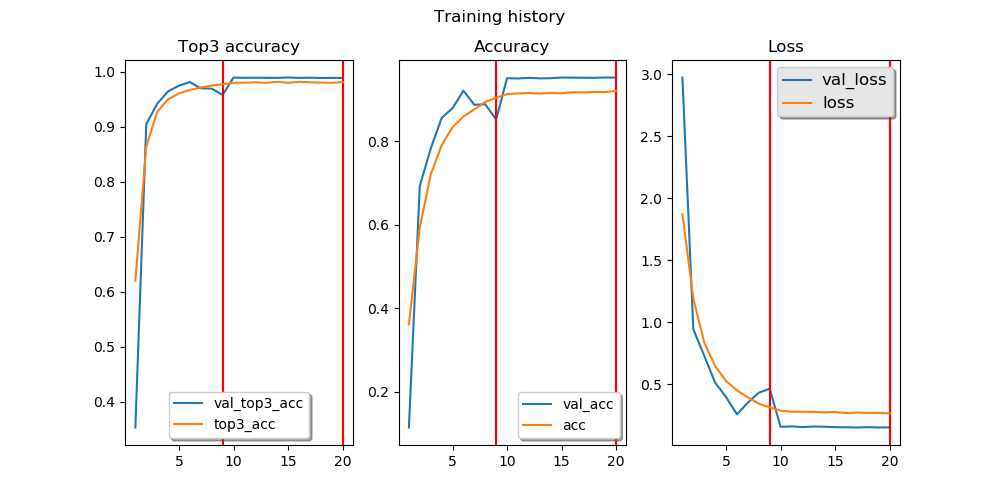

Normalized confusion matrix


<IPython.core.display.Javascript object>


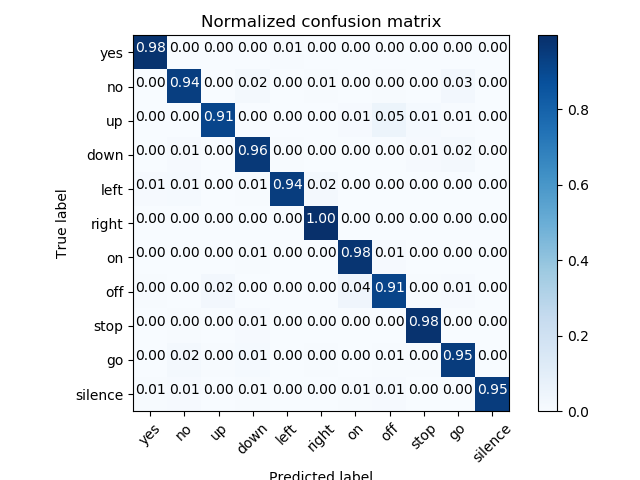

5852/5852 [==============================] - 2s 335us/step
Precision:  95.42 %
Wall time: 16min 33s


In [38]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.model2(inputData,inputLabel, baseDim = 40 )

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

## TinyDarknet

tinyDarknet
Using optimizer number 0
Train on 30881 samples, validate on 6813 samples
Epoch 1/20
30881/30881 [==============================] - 36s 1ms/step - loss: 2.7174 - acc: 0.4019 - top3_acc: 0.6787 - val_loss: 1.5415 - val_acc: 0.6630 - val_top3_acc: 0.9112
Epoch 2/20
30881/30881 [==============================] - 25s 801us/step - loss: 0.8164 - acc: 0.8076 - top3_acc: 0.9515 - val_loss: 1.6366 - val_acc: 0.7317 - val_top3_acc: 0.9278
Epoch 3/20
30881/30881 [==============================] - 25s 800us/step - loss: 0.5159 - acc: 0.8770 - top3_acc: 0.9695 - val_loss: 0.5685 - val_acc: 0.8754 - val_top3_acc: 0.9665
Epoch 4/20
30881/30881 [==============================] - 25s 801us/step - loss: 0.4232 - acc: 0.8984 - top3_acc: 0.9740 - val_loss: 2.0100 - val_acc: 0.6727 - val_top3_acc: 0.9034
Epoch 5/20
30881/30881 [==============================] - 25s 801us/step - loss: 0.3993 - acc: 0.9057 - top3_acc: 0.9762 - val_loss: 0.4121 - val_acc: 0.9130 - val_top3_acc: 0.9748
Epoch 6/20


C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


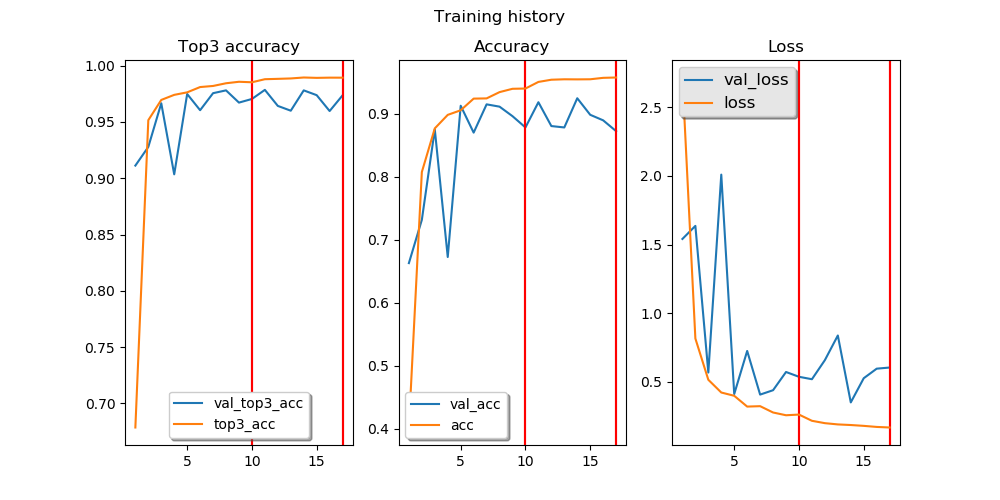

Normalized confusion matrix


<IPython.core.display.Javascript object>


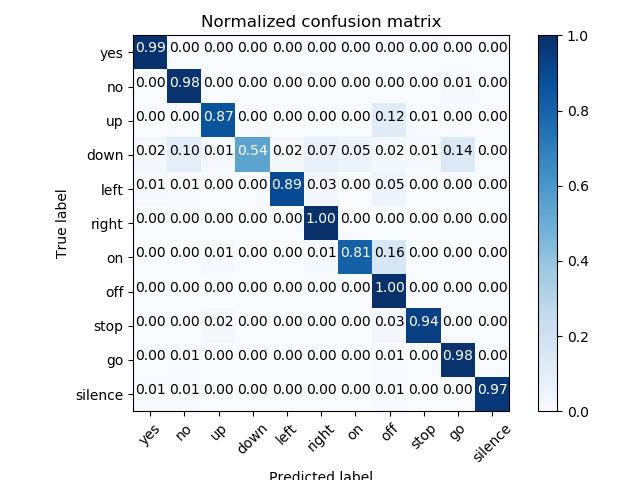

5852/5852 [==============================] - 2s 289us/step
Precision:  87.71 %
Wall time: 9min 52s


In [39]:
%%time
name = 'tinyDarknet'
print(name)
table = line
table['name'] =  name
table['augmented_set'] =  'No'

inputData, inputLabel, testData, testLabel, validData, validLabel, augmentedData, augmentedLabel, validation_data, loss_weights = functions.modelSelection(name, dataset, labels)

cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.3)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))

functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['feature'] =  choice
table['delta'] =  useDelta
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

Adding augmented dataset
Using optimizer number 0
Train on 52848 samples, validate on 6813 samples
Epoch 1/20
52848/52848 [==============================] - 47s 891us/step - loss: 2.2564 - acc: 0.5041 - top3_acc: 0.7426 - val_loss: 0.6704 - val_acc: 0.8509 - val_top3_acc: 0.9635
Epoch 2/20
52848/52848 [==============================] - 36s 684us/step - loss: 0.5304 - acc: 0.8712 - top3_acc: 0.9690 - val_loss: 0.4554 - val_acc: 0.8889 - val_top3_acc: 0.9768
Epoch 3/20
52848/52848 [==============================] - 36s 685us/step - loss: 0.3586 - acc: 0.9110 - top3_acc: 0.9782 - val_loss: 0.2791 - val_acc: 0.9323 - val_top3_acc: 0.9843
Epoch 4/20
52848/52848 [==============================] - 36s 685us/step - loss: 0.2928 - acc: 0.9299 - top3_acc: 0.9824 - val_loss: 0.2680 - val_acc: 0.9414 - val_top3_acc: 0.9830
Epoch 5/20
52848/52848 [==============================] - 36s 685us/step - loss: 0.2587 - acc: 0.9361 - top3_acc: 0.9842 - val_loss: 0.2218 - val_acc: 0.9507 - val_top3_acc: 0.9

C:\Users\yurin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


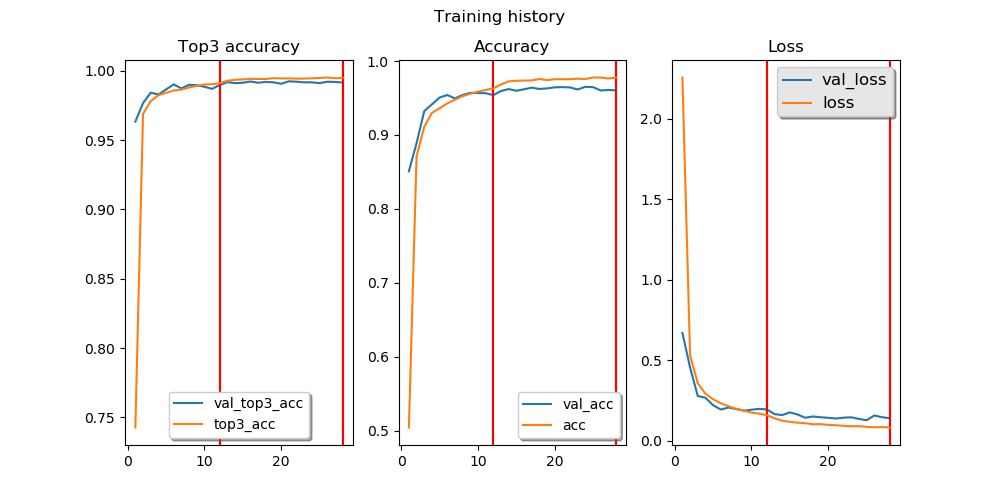

Normalized confusion matrix


<IPython.core.display.Javascript object>


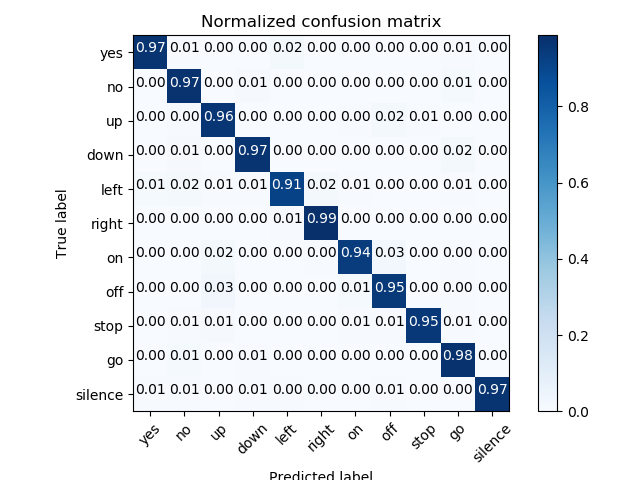

5852/5852 [==============================] - 2s 294us/step
Precision:  95.98 %
Wall time: 19min 29s


In [40]:
%%time
table['augmented_set'] =  'Yes'
cnn = models.tinyDarknet(inputData,inputLabel, dropout = 0.3)

print('Adding augmented dataset')
inputData, inputLabel = functions.meltData(inputData, augmentedData, inputLabel, augmentedLabel, 0.7)

fittedHistory = []

for count, optimizer in enumerate(optimizers):
    print('Using optimizer number ' + str(count))
    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy', top3_acc ], loss_weights=loss_weights)
    fittedHistory.append(cnn.fit(inputData, inputLabel,
                         epochs=epochs[count],
                         batch_size=round(inputData.shape[0]/400),
                         shuffle=True,
                         validation_data=validation_data,
                         callbacks = [esCallBack]))
    
functions.plotHistory(epochs, fittedHistory, 'Training History')

for count, fitted in enumerate(fittedHistory):
    n_epochs = len(fitted.history['loss'])
    if count == 0:
        table['epochSGD'] =  n_epochs
    else:
        table['epochAdam'] =  n_epochs
        
table['parameters'] =  cnn.count_params()

for key in fittedHistory[-1].history:
    if key in df.keys():
        table[key] =  fittedHistory[-1].history[key][-1]
        
micros = int(round(time.time() * 1000000))
# 100 times the prediction of test data
for i in range(100):
    preds = cnn.predict(testData)
    
micros = time.time() * 1000000 - micros
# normalize the time for single prediction
micros = micros/100/testData.shape[0]

table['inference_time'] =  micros

#Plot normalized confusion matrix
functions.plot_confusion_matrix(preds, testLabel, classes=labelList, normalize=True,
                      title='Normalized confusion matrix')
precision = cnn.evaluate(testData,  testLabel)
print ("Precision: ", round(precision[1]*100,2),"%")

table['test_acc'] =  round(precision[1],4)


df = df.append(table, ignore_index=True)

In [41]:
with open('variables/dataFrame.pkl', 'wb') as f:  
        pickle.dump(df, f)
df

name       acc   val_acc  val_top3_acc  test_acc    feature  delta  \
0        model1  0.891681  0.907383      0.977983    0.8994       mfcc  False   
1        model1  0.855283  0.880523      0.976075    0.8759       mfcc  False   
2        model2  0.910528  0.941142      0.986937    0.9298       mfcc  False   
3        model2  0.935797  0.947013      0.987377    0.9366       mfcc  False   
4   tinyDarknet  0.925747  0.843534      0.961838    0.8445       mfcc  False   
5   tinyDarknet  0.968419  0.949362      0.989138    0.9414       mfcc  False   
6       SiSoInc  0.948253  0.928225      0.984588    0.9270       mfcc  False   
7       SiSoInc  0.960907  0.933069      0.986790    0.9305       mfcc  False   
8        model1  0.910948  0.909438      0.978277    0.9009       mfcc   True   
9        model1  0.885010  0.822398      0.897989    0.8059       mfcc   True   
10       model2  0.945986  0.959489      0.990753    0.9528       mfcc   True   
11       model2  0.955457  0.958462      0.989285    0.9571       mfcc   True   
12  tinyDarknet  0.943396  0.887861      0.972993    0.8908       mfcc   True   
13  tinyDarknet  0.973149  0.959489      0.989872    0.9557       mfcc   True   
14      SiSoInc  0.962469  0.955526      0.988845    0.9549       mfcc   True   
15      SiSoInc  0.982819  0.956994      0.990313    0.9549       mfcc   True   
16      MiSoInc  0.972540  0.956407      0.990753    0.9557       mfcc   True   
17      MiSoInc  0.978826  0.955379      0.991634    0.9561       mfcc   True   
18       model2  0.938927  0.956700      0.991340    0.9585  logfilter  False   
19       model2  0.919827  0.951710      0.988698    0.9542  logfilter  False   
20  tinyDarknet  0.957806  0.872597      0.973580    0.8771  logfilter  False   
21  tinyDarknet  0.977615  0.960370      0.991634    0.9598  logfilter  False   

    inference_time augmented_set parameters epochSGD epochAdam  
0        58.667734            No     719947        9         8  
1        59.298392           Yes     719947        3         3  
2       140.188795            No     452691       20         7  
3       144.208705           Yes     452691       20         8  
4       132.517257            No    1153131        7        10  
5       134.177777           Yes    1153131       15         7  
6        58.034527            No     163791       20         5  
7        60.263105           Yes     163791       20         7  
8        98.949593            No     723531       10         5  
9       104.695372           Yes     723531        3         3  
10      181.483213            No     453331       20        10  
11      184.922552           Yes     453331       17         5  
12      169.962916            No    1153707        9         4  
13      180.559575           Yes    1153707       16         7  
14      112.350368            No     183391       13         4  
15      116.980170           Yes     183391       14         4  
16      169.896536            No     406871       12         4  
17      188.942458           Yes     406871       11         6  
18      298.303972            No     606291       19        14  
19      306.535387           Yes     606291        9        11  
20      262.228284            No    1153131       10         7  
21      269.820231           Yes    1153131       12        16